In [1]:
import json
import numpy as np
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
import torch
import time


class MyDynamicDatasetLoader(object):
    def __init__(self):
        self._read_web_data()

    def _read_web_data(self):
        with open('data/graphs/grafo_corr_sliding.json') as f:
            self._dataset = json.load(f)

    def _get_edges(self):
        self._edges = []
        for time in self._dataset["time_periods"]:
            self._edges.append(
                np.array(self._dataset["edge_mapping"]["edge_index"][str(time)]).T
            )

    def _get_node_ids(self):
        self._node_ids = np.array(self._dataset["node_ids"])
    
    def _get_edge_weights(self):
        self._edge_weights = []
        for time in self._dataset["time_periods"]:
            self._edge_weights.append(
                np.array(self._dataset["edge_mapping"]["edge_weight"][str(time)])
            )

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["y"])
        self.scale = []
        for i in range(24):
            self.scale.append(max(stacked_target[:,i]))
        self.scale = np.array(self.scale)*100
        self.mu = np.mean(stacked_target, axis=0)
        self.sigma = np.std(stacked_target, axis=0)
        standardized_target = (stacked_target - self.mu) / (self.sigma + 10 ** -10)
        #standardized_target = stacked_target/self.scale
        self.features = [
            standardized_target[i : i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"]))
        ]
        self.targets = [
            standardized_target[i + self.lags, :].T
            for i in range(len(self._dataset["time_periods"]))
        ]

    def get_dataset(self, lags: int = 4) -> DynamicGraphTemporalSignal:
        """Returning the Wind Speed data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(StaticGraphTemporalSignal)* - The Wind Speed dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_node_ids()
        self._get_targets_and_features()
        dataset = DynamicGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset


In [2]:
lags = 3
loader = MyDynamicDatasetLoader()
dataset = loader.get_dataset(lags=lags)
dataset[1]

IndexError: index 7941 is out of bounds for axis 0 with size 7941

In [3]:
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch_geometric_temporal.nn.recurrent import GConvGRU, TGCN, GConvLSTM, DCRNN
from torch_geometric_temporal.signal import temporal_signal_split
from updated_models.DCRNN_up import DCRNN_hidden

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

NameError: name 'dataset' is not defined

In [59]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(in_channels=node_features, out_channels=10, K=5)#, add_self_loops=False
        self.linear = torch.nn.Linear(10, 1)

    def forward(self, x, edge_index, edge_weight, H):
        H = self.recurrent(x, edge_index, edge_weight, H) #####tuple in caso di lstm
        h = H
        h = F.relu(h)
        h = self.linear(h)
        return h,H

In [58]:
model = RecurrentGCN(node_features = lags)
name_model = model.recurrent.__class__.__name__
name_model

'DCRNN_hidden'

In [8]:
sigma = loader.sigma
mu = loader.mu
scale = loader.scale
def descale(output, sigma, mu, scale):
    return output* sigma + mu#scale

In [55]:
#model = model.to('cuda')
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = F.mse_loss

start_time = time.perf_counter() # Start timer
num_epochs = 10
losses = []
outputs = []  #
targets = []  #
for epoch in range(num_epochs):
    loss = 0
    epoch_outputs = []  #
    epoch_targets = []  #
    H = torch.zeros(24, 10)
    print("  Epoch %d/%d" % (epoch+1,num_epochs))
    for time_step, snapshot in enumerate(train_dataset):
        #snapshot.to('cuda')
        output, H = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, H=H)
        loss = loss + loss_fn(output.T[0], snapshot.y)
        epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale))  #
        epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale))   #

    loss = loss/(time_step+1)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    losses.append(loss.cpu().detach().numpy())
    outputs.append(epoch_outputs)  #
    targets.append(epoch_targets)  #
    print('Training loss: ', losses[-1])

end_time = time.perf_counter() # End timer
print("Elapsed time: ", end_time - start_time) # Calculate elapsed time
 
plt.plot(losses)
plt.xlabel("epoch")

  Epoch 1/10
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a
bbbbbbbbbbbbbbbbbb
a


KeyboardInterrupt: 

In [ ]:
# a=model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
# print(a)

In [ ]:
# print(epoch_outputs.append(descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)))
# print(epoch_targets.append(descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)))

In [42]:
outputs_hourly = []
targets_hourly = []
for j in range(24):
    outhourlist = [outputs[-1][i][j] for i in range(len(outputs[-1]))]
    tarhourlist = [targets[-1][i][j] for i in range(len(outputs[-1]))]
    outputs_hourly.append(outhourlist)
    targets_hourly.append(tarhourlist)

In [43]:
#Test set
test_outputs = []  #
test_targets = []  #
for time_step, snapshot in enumerate(test_dataset):
    #snapshot.to('cuda')
    output = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    test_output = descale(output.T[0].detach().cpu().numpy(), sigma, mu, scale)
    test_snapshot = descale(snapshot.y.detach().cpu().numpy(), sigma, mu, scale)
    test_outputs.append(test_output)  #
    test_targets.append(test_snapshot)   #
#snapshot.x


In [44]:
outputs_hourly_test = []
targets_hourly_test = []
for j in range(24):
    outhourlist = [test_outputs[i][j] for i in range(len(test_outputs))]
    tarhourlist = [test_targets[i][j] for i in range(len(test_outputs))]
    outputs_hourly_test.append(outhourlist)
    targets_hourly_test.append(tarhourlist)

In [45]:
mse_test = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
    mse_test.append(np.mean(sqdiff))
mse_test

[321.53845410984354,
 114.12398178998504,
 114.98508144449697,
 175.80488022982874,
 273.57480771434183,
 1098.2611570974811,
 3396.005100765069,
 4925.678969822673,
 6055.367014574921,
 7595.30289556186,
 10422.473334728904,
 11913.522578988848,
 10039.510469593892,
 13384.074207469737,
 13573.125670642336,
 14422.99030681234,
 19688.17623445028,
 22031.590585657385,
 14927.460427588092,
 10647.637505419252,
 6974.651442608723,
 3516.0278402028543,
 1392.0307848194145,
 929.202075072517]

In [46]:
np.mean(mse_test)

7413.879825298546

In [47]:
mse_train = []
for j in range(24):
    sqdiff = [(a - b)**2 for a, b in zip(targets_hourly[j], outputs_hourly[j])]
    mse_train.append(np.mean(sqdiff))
mse_train

[799.3917323958401,
 635.427275220539,
 369.08293523412794,
 291.2226294133188,
 345.9873680567778,
 503.2451249601747,
 3305.1077230353935,
 4066.908830800569,
 5515.81844134911,
 7284.884219157035,
 10543.262878446349,
 13788.345488891191,
 14159.938966684875,
 15902.113315564542,
 16515.966847831955,
 16657.57806425998,
 19366.317938592587,
 25500.229938542183,
 15567.30763060909,
 11762.806743513074,
 9031.269936096143,
 7467.075253452117,
 2057.2336061274486,
 1880.8422757530705]

In [48]:
np.mean(mse_train)

8471.556881832812

In [49]:
#unisco train e test
outputs_merged = [l1 + l2 for l1, l2 in zip(outputs_hourly, outputs_hourly_test)]
targets_merged = [l1 + l2 for l1, l2 in zip(targets_hourly, targets_hourly_test)]

In [51]:
list_ids = loader._node_ids
dict = list_ids.item()
inverse_dict = {value: key for key, value in dict.items()}
inverse_dict.get(0)

'00:00'

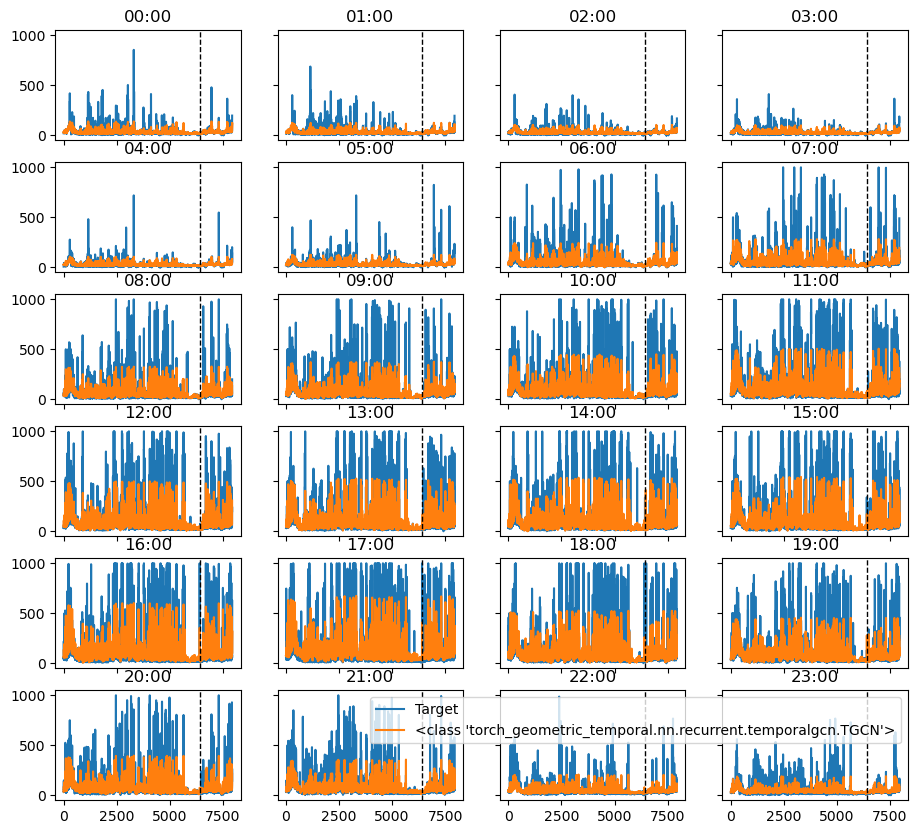

In [52]:
fig, axs = plt.subplots(6, 4, figsize=(11, 10), sharey=True, sharex=True)

# Iteriamo sulla lista delle matrici e le visualizziamo in subplots
for i in range(6):
    axs[i,0].plot(targets_merged[i*4], label="Target")
    axs[i,0].plot(outputs_merged[i*4], label=name_model)
    axs[i,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,1].plot(targets_merged[i*4+1], label="Target")
    axs[i,1].plot(outputs_merged[i*4+1], label=name_model)
    axs[i,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,2].plot(targets_merged[i*4+2], label="Target")
    axs[i,2].plot(outputs_merged[i*4+2], label=name_model)
    axs[i,2].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,3].plot(targets_merged[i*4+3], label="Target")
    axs[i,3].plot(outputs_merged[i*4+3], label=name_model)
    axs[i,3].axvline(x=6420, color='black', linestyle='--', linewidth=1)
    axs[i,0].set_title(inverse_dict[i*4])  # Titolo del subplot
    axs[i,1].set_title(inverse_dict[i*4+1])
    axs[i,2].set_title(inverse_dict[i*4+2])
    axs[i,3].set_title(inverse_dict[i*4+3])
    #axs[i].axis('off')  # Nasconde gli assi

plt.legend()
plt.savefig('plot/dyn'+name_model.lower()+'.jpg', format='jpg')
# Mostriamo la figura con tutti i subplot
plt.show()

In [ ]:
hour = 3

diff = [a - b for a, b in zip(targets_merged[j], outputs_merged[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_merged[hour], label="Ground Truth")
axs[0].plot(outputs_merged[hour], label=name_model)
axs[0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour])
axs[1].plot(diff, label="Residual")
axs[1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

In [ ]:
hour = 3

diff = [a - b for a, b in zip(targets_hourly_test[j], outputs_hourly_test[j])]
fig, axs = plt.subplots(2, 1, figsize=(9, 8))
axs[0].plot(targets_hourly_test[hour][:1000], label="Ground Truth")
axs[0].plot(outputs_hourly_test[hour][:1000], label=name_model)
axs[0].legend()
axs[0].set_title("Daily series at "+inverse_dict[hour]+" in the test set")
axs[1].plot(diff[:1000], label="Residual")
axs[1].legend()
axs[1].set_title("Residuals")
plt.show()

In [ ]:
hour1 = 2
hour2 = 16

diff1 = [a - b for a, b in zip(targets_merged[hour1], outputs_merged[hour1])]
diff2 = [a - b for a, b in zip(targets_merged[hour2], outputs_merged[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_merged[hour1], label="Ground Truth")
axs[0,0].plot(outputs_merged[hour1], label=name_model)
axs[0,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,0].legend()
axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1])
axs[1,0].plot(diff1, label="Residual")
axs[1,0].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,0].legend()
axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_merged[hour2], label="Ground Truth")
axs[0,1].plot(outputs_merged[hour2], label=name_model)
axs[0,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[0,1].legend()
axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2])
axs[1,1].plot(diff2, label="Residual")
axs[1,1].axvline(x=6420, color='black', linestyle='--', linewidth=1)
axs[1,1].legend()
axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focusdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [ ]:
hour1 = 2
hour2 = 16
fd=500

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][:fd], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][:fd], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in first "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[:fd], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][:fd], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][:fd], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in first "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[:fd], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()

In [ ]:
#o uno o l'altro
hour1 = 2
hour2 = 16
fd=100

diff1 = [a - b for a, b in zip(targets_hourly_test[hour1], outputs_hourly_test[hour1])]
diff2 = [a - b for a, b in zip(targets_hourly_test[hour2], outputs_hourly_test[hour2])]
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].plot(targets_hourly_test[hour1][-fd:], label="Ground Truth")
axs[0,0].plot(outputs_hourly_test[hour1][-fd:], label=name_model)
axs[0,0].legend()
#axs[0,0].set_ylim(-40,1040)
axs[0,0].set_title("Daily series at "+inverse_dict[hour1]+" in last "+str(fd)+" days of the test set")
axs[1,0].plot(diff1[:fd], label="Residual")
axs[1,0].legend()
#axs[1,0].set_ylim(-1040,1040)
axs[1,0].set_title("Residuals")
axs[0,1].plot(targets_hourly_test[hour2][-fd:], label="Ground Truth")
axs[0,1].plot(outputs_hourly_test[hour2][-fd:], label=name_model)
axs[0,1].legend()
#axs[0,1].set_ylim(-40,1040)
axs[0,1].set_title("Daily series at "+inverse_dict[hour2]+" in last "+str(fd)+" days of the test set")
axs[1,1].plot(diff2[:fd], label="Residual")
axs[1,1].legend()
#axs[1,1].set_ylim(-1040,1040)
axs[1,1].set_title("Residuals")
plt.savefig('plot/focustestdyn'+name_model.lower()+'.jpg', format='jpg')
plt.show()